In [1]:
#get MNIST data
#first import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import gzip
import tensorflow as tf
from skimage.transform import downscale_local_mean
import scipy.stats
from tqdm import tqdm





In [2]:
#get the data from keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print('X_train: ' + str(X_train.shape)) #60000 observations, 28 x 28 matrices
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [3]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

  0%|          | 0/2 [00:00<?, ?it/s]

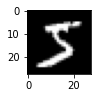

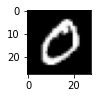

100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


In [4]:
from matplotlib import pyplot
#take a look at a couple of the images for fun
for i in tqdm(range(2)):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [5]:
factors = (2,2) #2x2 blocks 

#initialize downscaled 3dimensional array
X_train_ds = list()
#for each image in the training data set, downscale by calculating the local mean of each 2x2 block and create a new 14x14 image
for i in range(len(X_train)):
    #downscale the bih
    ith_downscaled_image = downscale_local_mean(X_train[i], factors, cval=0, clip=True)
    
    #append it to downscaled training data
    X_train_ds.append(ith_downscaled_image)
    
#make it a 3 d array
X_train_ds = np.array(X_train_ds)

In [6]:
X_train_ds.shape #seems to have worked, X_train_ds is the downscaled version, each element is a 14 by 14 matrix

#for using in (the EM) algorithm, each sample should be treated as a vector (14x14 = 196 dimensional vector)
X_train_vectorized = X_train_ds.reshape(60000,196)

In [7]:
#for our purposes we only want to consider image 5 image classes: {0,1,2,3,4}
#drop the rest

#find the indices from y_train that are 5,6,7,8,9
bool_arr = (y_train >= 5) #find the indices of the images we don't want to cluster/consider
drop_indices = np.where(bool_arr)

#delete them from y_train
y_train_0_4 = np.delete(y_train, drop_indices)

#delete them from X_train as well
X_train_vectorized_0_4 = np.delete(X_train_vectorized, drop_indices, axis = 0) #drop the correct indices row-wise (axis = 0)
#remember, each row now corresponds to an image

In [8]:


probs = [1/2,1/2] #2 classes
k = len(probs)
#mu vectors:
new_X = np.array_split(X_train_vectorized_0_4,k) #mu vector for each of the k classes
mus = np.array([np.mean(x,axis = 0) for x in new_X])
sigmas = [np.eye(196,196) for i in range(len(probs))]
# cov_matrices = np.array([np.cov(x.T) for x in new_X])
f_ij = np.zeros((len(X_train_vectorized_0_4),k))

In [24]:
sigmas = np.array([np.eye(3,3) for i in range(2)])
sigmas.shape

(2, 3, 3)

**EM Algorithm**

In [114]:
#Assume 5 clusters/classes
def em(data, k: int = 5, max_iter = 100, spherical = False, seed = 42):

    '''
    'data' is the dataset being clustered
    'k" is the number of classes we are assuming for the latent variable
    'max_iter' is the number of iterations for the EM algorithm to run    
    '''
    np.random.seed(seed)
    #first initialize the maw fuckas
    n,p = data.shape #number of rows (n), number of columns (p)
    mus = np.random.rand(k,p) #need k mu vectors each of size p (196)
    class_probs = np.ones(k)*(1/k) #initialize with equal probability weights
    #spherical vs diagonal sigmas
    if spherical == False: #diagonal
        sigmas = np.array([np.diag(np.random.rand(p)) for _ in range(k)])

    else: #spherical (all the same covariances along the diagonal)
        sigmas = np.array([np.diag(np.ones(p)*np.random.rand()) for _ in range(k)])


    #initialize empty responsibilities matrix
    log_responsibilities = np.zeros(shape = (n,k)) #each observation/row/image should have k probs associated with it (representing prob it belongs to the jth class)
    responsibilities = np.zeros(shape = (n,k))
    #iterate 
    for _ in tqdm(range(max_iter)):
        #### E-Step
        for j in range(k):
            log_responsibilities[:,j] = scipy.stats.multivariate_normal(mean = mus[j], cov=sigmas[j]).logpdf(data) + np.log(class_probs[j])

            #use sumlogexp rule to convert to actual probabilities that aren't logged
            responsibilities[:,j] = scipy.special.logsumexp(log_responsibilities[:,j])

            

        #before M step, normalize rows to sum to 1 
        normalized_responsibilities = responsibilities/np.sum(responsibilities,axis=1, keepdims=1)


        #calculate the class probabilities
        class_resps = np.sum(normalized_responsibilities, axis = 0)


        #### M-Step

        #update class probabilities
        class_probs = class_resps/n

        #update mu vector
        

    return class_probs, mus, sigmas,normalized_responsibilities
        


In [93]:
test_class_probs = np.array([.5,.5]) # 2 classes

# 3 variables essentially, so 3 means in each mu vector (2 mu vectors, one for each of the 2 classes)
test_mu = np.array([
    [.5,-.5,-4],[-3,-2,2]])
test_sigma  = \
np.array([
    [
    [1, .25, .25],
    [.25, .5, .25],
    [.25, .25, .5],
    ],
    [
    [2, 1, 1],
    [1, 3, 1],
    [1, 1, 2],
    ]
])

In [103]:
test_data = np.random.multivariate_normal(mean = test_mu[0], cov = test_sigma[0],size = 10) #generate sample data 10 rows (3 dimensional)
resp = np.zeros(shape = (10,len(test_class_probs))) #for each of the 10 rows, there should be 2 probabilities, each representing the probability the ith row belongs to jth class
for j in range(len(test_class_probs)):
    resp[:,j] = scipy.stats.multivariate_normal(mean = test_mu[j], cov = test_sigma[j]).pdf(test_data) * test_class_probs[j]

#normalize so rows sum to 1
resp_normalized = resp / np.sum(resp,axis = 1,keepdims=1)

In [115]:
returned_class_probs, returned_mus, returned_sigmas,norm_resps = em(X_train_vectorized_0_4,k = 5,spherical = True)

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


In [116]:
returned_class_probs

array([0.10570311, 0.04582499, 0.33071679, 0.4692426 , 0.04851252])

In [101]:
returned_sigmas


array([[[0.49549132, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.49549132, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.49549132, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.49549132,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.49549132, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.49549132]],

       [[0.6884024 , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.6884024 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.6884024 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.6884024 ,
         0.        , 0.        ],
        [0. 

In [81]:
scipy.stats.multivariate_normal(mean = returned_mus[1], cov=returned_sigmas[1]).pdf(X_train_vectorized_0_4) * returned_class_probs[1]

array([0., 0., 0., ..., 0., 0., 0.])